### Libraries

In [ ]:
!pip install pyts

In [ ]:
!pip install keras-tuner


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import datetime

In [ ]:
from pyts.image import GramianAngularField

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Step 1

In [ ]:
# Download stock price of JPMorgan, from 2017-01-01 to 2024-01-01
start = "2017-01-01"
end = "2024-01-01"
df = yf.download("JPM", start, end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.shape

(1760, 6)

In [ ]:
df.head()

Price       Adj Close      Close       High        Low       Open    Volume
Ticker            JPM        JPM        JPM        JPM        JPM       JPM
Date                                                                       
2017-01-03  69.970299  87.230003  87.760002  85.980003  87.339996  20550700
2017-01-04  70.099365  86.910004  87.180000  86.400002  86.959999  15266600
2017-01-05  69.454094  86.110001  87.110001  85.260002  86.809998  14300800
2017-01-06  69.462143  86.120003  86.620003  85.940002  86.389999  12893300
2017-01-09  69.510551  86.180000  86.769997  85.519997  85.730003  12806600

In [ ]:
df1 = df["Adj Close"]
df1.describe()

Ticker          JPM
count   1760.000000
mean     108.466271
std       25.615222
min       66.640778
25%       88.317183
50%      101.835438
75%      133.327751
max      166.328201

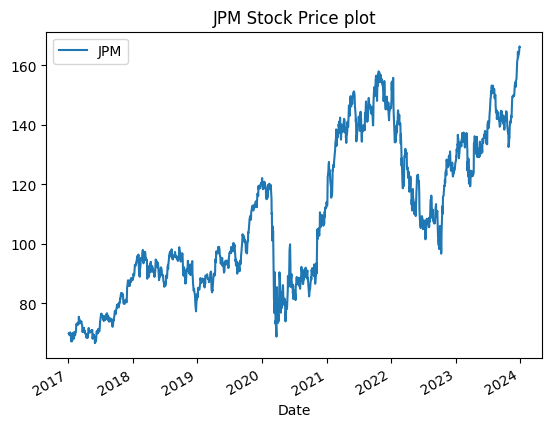

In [ ]:
df1.plot()
plt.legend()
plt.title("JPM Stock Price plot");

In [ ]:
# Calculate returns for JPM
df1["Ret"] = df1["JPM"].pct_change()
df1 = df1.reset_index()
df1.dropna(inplace=True)
df1.drop(columns=["JPM"], inplace=True)

## Build model using MLP

In [ ]:
# Create features using different lags
n_lags = 30

for i in range(1, n_lags + 1, 2):
    name = "Ret_" + str(i)
    df1[name] = df1["Ret"].rolling(i).apply(lambda x: (np.prod(1 + x) - 1))

In [ ]:
# Use labels that include some leakage of information between training and test samples. In this case, there is leakage of 5 days.
df1["Ret10_i"] = df1["Ret"].rolling(10).apply(lambda x: (np.prod(1 + x) - 1))
df1["Ret5"] = df1["Ret10_i"].shift(-5)
df1["Output"] = df1["Ret5"] > 0
df1["Output"] = df1["Output"].astype(int)
del df1["Ret5"]
del df1["Ret10_i"]
df1 = df1.dropna()

In [ ]:
# Split the timing for test sample, 20% for test sample
ts = int(0.2 * len(df1))
split_time = len(df1) - ts
test_time = df1.iloc[split_time:, 0:1].values
Ret_vector = df1.iloc[split_time:, 1:2].values

In [ ]:
# Perform train-test split
Xdf, ydf = df1.iloc[:, 2:-1], df1.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=False
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1385, 15) (346, 15) (1385,) (346,)


In [ ]:
#Set up MLP model
tf.keras.backend.clear_session()  # Clear the backend to reset the random seed process
tf.random.set_seed(
    1234
)  # Set a random seed

act_fun = "relu"
hp_units = 30
hp_units_2 = 20
hp_units_3 = 10
n_dropout = 0.2

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

hp_lr = 1e-5  # Learning rate

adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],

)

Epoch 1/500
35/35 - 5s - 139ms/step - accuracy: 0.5578 - loss: 0.6891 - val_accuracy: 0.4188 - val_loss: 0.6966
Epoch 2/500
35/35 - 0s - 8ms/step - accuracy: 0.5523 - loss: 0.6883 - val_accuracy: 0.4224 - val_loss: 0.6966
Epoch 3/500
35/35 - 0s - 4ms/step - accuracy: 0.5442 - loss: 0.6891 - val_accuracy: 0.4260 - val_loss: 0.6966
Epoch 4/500
35/35 - 0s - 4ms/step - accuracy: 0.5632 - loss: 0.6877 - val_accuracy: 0.4296 - val_loss: 0.6966
Epoch 5/500
35/35 - 0s - 4ms/step - accuracy: 0.5596 - loss: 0.6876 - val_accuracy: 0.4368 - val_loss: 0.6966
Epoch 6/500
35/35 - 0s - 4ms/step - accuracy: 0.5578 - loss: 0.6877 - val_accuracy: 0.4404 - val_loss: 0.6966
Epoch 7/500
35/35 - 0s - 4ms/step - accuracy: 0.5668 - loss: 0.6872 - val_accuracy: 0.4404 - val_loss: 0.6966
Epoch 8/500
35/35 - 0s - 4ms/step - accuracy: 0.5650 - loss: 0.6875 - val_accuracy: 0.4404 - val_loss: 0.6966
Epoch 9/500
35/35 - 0s - 3ms/step - accuracy: 0.5578 - loss: 0.6870 - val_accuracy: 0.4404 - val_loss: 0.6966
Epoch 10

In [ ]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5579 - loss: 0.6846 
Model accuracy in test:  [0.684619665145874, 0.586705207824707]


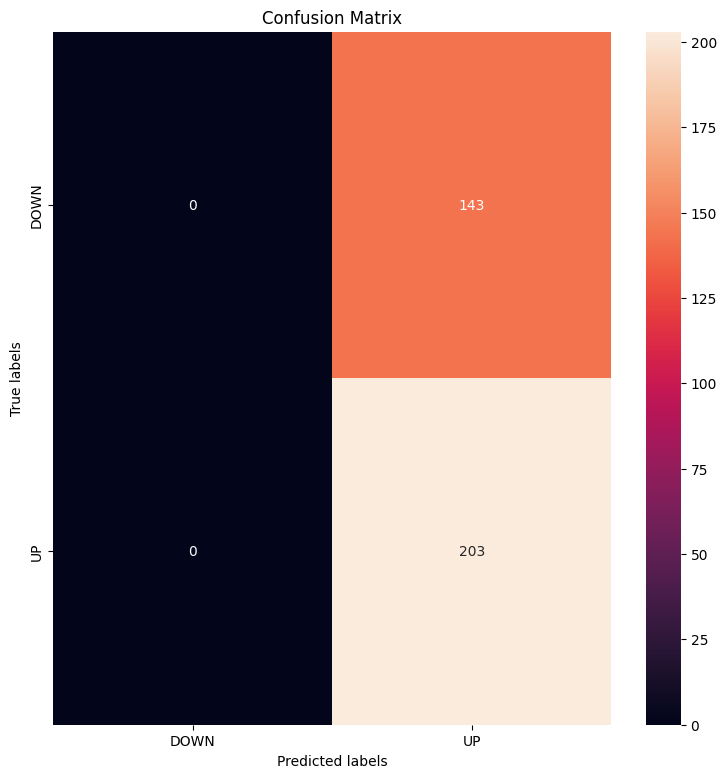

In [ ]:
# Create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
# annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["DOWN", "UP"])
ax.yaxis.set_ticklabels(["DOWN", "UP"]);

In [ ]:
df1_predictions = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred.flatten(),
        "Ret": (Ret_vector.flatten()),
    }
)
df1_predictions.tail()

Date  Pred       Ret
341 2023-12-22     1 -0.000597
342 2023-12-26     1  0.005914
343 2023-12-27     1  0.005998
344 2023-12-28     1  0.005313
345 2023-12-29     1 -0.001174

In [ ]:
# Calculate different strategy backtest returns
df1_predictions["Positions"] = np.where(df1_predictions["Pred"] > 0.5, 1, -1)
df1_predictions["Strat_ret"] = df1_predictions["Positions"].shift(1) * df1_predictions["Ret"]
df1_predictions["Positions_L"] = df1_predictions["Positions"].shift(1)
df1_predictions["Positions_L"][df1_predictions["Positions_L"] == -1] = 0
df1_predictions["Strat_ret_L"] = df1_predictions["Positions_L"] * df1_predictions["Ret"]
df1_predictions["CumRet"] = df1_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df1_predictions["CumRet_L"] = df1_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df1_predictions["bhRet"] = df1_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df1_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df1_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df1_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Strat Return Long Only = 42.95694701904824 %
Strat Return = 42.95694701904824 %
Buy and Hold Return = 44.3227823398028 %


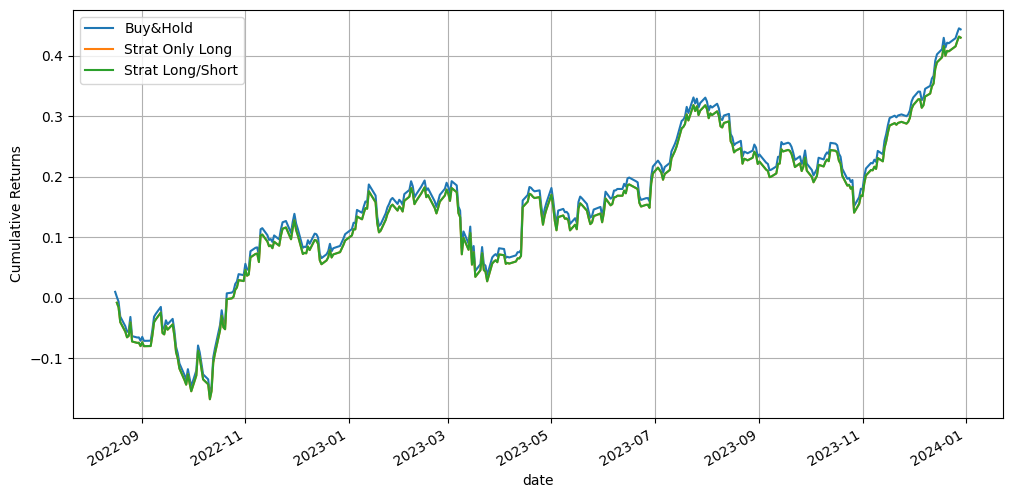

Date   Pred         Ret  Positions  \
count                            346  346.0  346.000000      346.0   
mean   2023-04-23 06:39:32.254335232    1.0    0.001166        1.0   
min              2022-08-16 00:00:00    1.0   -0.054136        1.0   
25%              2022-12-16 18:00:00    1.0   -0.006722        1.0   
50%              2023-04-24 12:00:00    1.0    0.001865        1.0   
75%              2023-08-27 06:00:00    1.0    0.008311        1.0   
max              2023-12-29 00:00:00    1.0    0.075510        1.0   
std                              NaN    0.0    0.014518        0.0   

        Strat_ret  Positions_L  Strat_ret_L      CumRet    CumRet_L  \
count  345.000000        345.0   345.000000  345.000000  345.000000   
mean     0.001141          1.0     0.001141    0.142770    0.142770   
min     -0.054136          1.0    -0.054136   -0.167902   -0.167902   
25%     -0.006729          1.0    -0.006729    0.072766    0.072766   
50%      0.001826          1.0     0.001826    0.152475    0.152475   
75%      0.008132          1.0     0.008132    0.221459    0.221459   
max      0.075510          1.0     0.075510    0.431250    0.431250   
std      0.014532          0.0     0.014532    0.122913    0.122913   

            bhRet  
count  346.000000  
mean     0.153272  
min     -0.159952  
25%      0.082521  
50%      0.162775  
75%      0.233066  
max      0.444925  
std      0.124149

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df1_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df1_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df1_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df1_predictions.describe()

## Build model using LSTM

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import datetime

In [ ]:
# Define the parameters

start = "2017-01-01"
end = "2023-12-31"
etf = "JPM"
# Parameters
SEED = 1234
units_lstm = 30
n_dropout = 0.2
act_fun = "relu"

In [ ]:
#Get data
df = yf.download(etf, start, end)["Adj Close"].reset_index()
df["Ret"] = df['JPM'].pct_change()
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [ ]:
## Introduce leakage: Calculate future 5-day returns for JPM
df2 = df[["Date", "Ret"]]
df2["Ret_5"] = df2["Ret"].rolling(5).apply(lambda x: np.prod(1 + x / 100) - 1)
df2["Ret5"] = df2["Ret_5"].shift(-5)
del df2["Ret_5"]
df2 = df2.dropna()
df2.head()

Ticker       Date       Ret      Ret5
1      2017-01-04  0.001845  0.000020
2      2017-01-05 -0.009205  0.000016
3      2017-01-06  0.000116  0.000068
4      2017-01-09  0.000697 -0.000302
5      2017-01-10  0.002901 -0.000285

In [ ]:
# Define Train, val, test samples

Xdf, ydf = df2.iloc[:, 1:-1], df2.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

In [ ]:
## define the validation, train, and test samples

val_split = 0.2
train_split = 0.625
train_size = int(len(df2) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df2) - train_size)

window_size = 30

ts = test_size
split_time = len(df2) - ts
test_time = df2.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [ ]:
## Scale data

scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [ ]:
# Split data

training_time = df2.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (1066, 30, 1) (1066, 1)
Shape of test data (628, 30, 1) (658, 1)


In [ ]:


model = Sequential()

model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
)
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))


model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))


model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=10, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 30)              │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 30)              │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 30)              │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30)                  │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,641 (104.07 KB)

 Trainable params: 26,641 (104.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compiler

hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
14/14 - 10s - 691ms/step - loss: 0.1932 - val_loss: 0.2157
Epoch 2/100
14/14 - 1s - 86ms/step - loss: 0.1709 - val_loss: 0.1887
Epoch 3/100
14/14 - 1s - 91ms/step - loss: 0.1478 - val_loss: 0.1562
Epoch 4/100
14/14 - 1s - 58ms/step - loss: 0.1354 - val_loss: 0.1399
Epoch 5/100
14/14 - 1s - 63ms/step - loss: 0.1364 - val_loss: 0.1426
Epoch 6/100
14/14 - 1s - 75ms/step - loss: 0.1332 - val_loss: 0.1453
Epoch 7/100
14/14 - 1s - 88ms/step - loss: 0.1321 - val_loss: 0.1420
Epoch 8/100
14/14 - 1s - 99ms/step - loss: 0.1325 - val_loss: 0.1419
Epoch 9/100
14/14 - 1s - 58ms/step - loss: 0.1307 - val_loss: 0.1418


In [ ]:
#Make prediction

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

#
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "Ret": values}
)
df_predictions.head()

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Out-of-sample R-squared: 0.005995855985019616


Date  Pred LSTM           Ret
0 2021-06-25   0.000015  1.861052e-04
1 2021-06-28   0.000020 -2.040383e-08
2 2021-06-29   0.000023  2.402564e-05
3 2021-06-30   0.000024 -2.393220e-04
4 2021-07-01   0.000023 -1.841028e-05

<ipython-input-96-a79e66993f32>:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_predictions["Positions_L"][df_predictions["Positions_L"] == -1] = 0
<ipython-input-96-a79e66993f32>:15: SettingWithCopyWarning: 
A value is trying to be set

Strat Return = 1.2366175651550293 %
Strat_L Return = 1.2026309967041016 %
Buy and Hold Return = 1.181018352508545 %


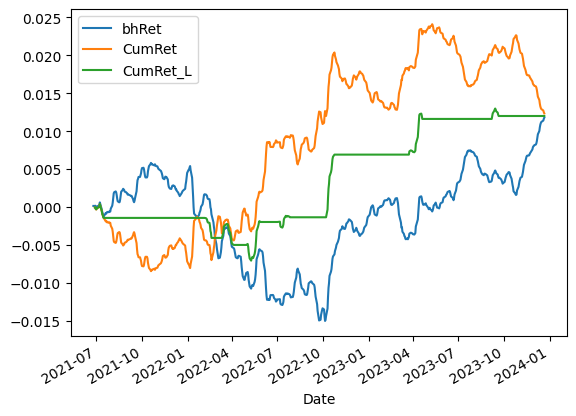

In [ ]:
# Back-test
df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["Ret"]
)
df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["bhRet"] = (
    df_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

# Long-only strategy
df_predictions["Positions_L"] = df_predictions["Positions"].shift(1)
df_predictions["Positions_L"][df_predictions["Positions_L"] == -1] = 0
df_predictions["Strat_ret_L"] = df_predictions["Positions_L"] * df_predictions["Ret"]
df_predictions["CumRet_L"] = df_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["Ret"]) - 1
Final_Return_L = np.prod(1 + df_predictions["Strat_ret_L"]) - 1


print("Strat Return =", Final_Return * 100, "%")
print("Strat_L Return =", Final_Return_L * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

ax = plt.gca()
df_predictions.plot(x="Date", y="bhRet", ax=ax)
df_predictions.plot(x="Date", y="CumRet", ax=ax)
df_predictions.plot(x="Date", y="CumRet_L", ax=ax)
plt.show();

## Build model using CNN based on GAF

In [ ]:
# Initialize the GAF transformer
gaf = GramianAngularField(image_size=15 , method="summation")

# Convert the returns column into GAF images
X_gaf = gaf.fit_transform(X)  # X contains the lagged features
X_gaf = np.expand_dims(X_gaf, axis=-1)  # Add channel dimension for CNN

# Train-test split
X_train_gaf, X_test_gaf = X_gaf[:split_time], X_gaf[split_time:]
y_train, y_test = y[:split_time], y[split_time:]

print(X_train_gaf.shape, X_test_gaf.shape, y_train.shape, y_test.shape)


(1385, 15, 15, 1) (346, 15, 15, 1) (1385,) (346,)


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

model_cnn = tf.keras.models.Sequential()

# Input layer with 15x15x1 input
model_cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', input_shape=(15, 15, 1)))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second Conv layer
model_cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME'))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model_cnn.add(tf.keras.layers.Flatten())

# Fully connected layer
model_cnn.add(tf.keras.layers.Dense(128, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.5))

# Output layer for binary classification
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 15, 15, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,801 (362.50 KB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping
es_cnn = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

In [ ]:
history_cnn = model_cnn.fit(
    X_train_gaf,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks=[es_cnn],
)


Epoch 1/100
35/35 - 2s - 70ms/step - accuracy: 0.5659 - loss: 0.6850 - val_accuracy: 0.4585 - val_loss: 0.7085
Epoch 2/100
35/35 - 1s - 23ms/step - accuracy: 0.6020 - loss: 0.6610 - val_accuracy: 0.5018 - val_loss: 0.7104
Epoch 3/100
35/35 - 1s - 38ms/step - accuracy: 0.6209 - loss: 0.6563 - val_accuracy: 0.4982 - val_loss: 0.7197
Epoch 4/100
35/35 - 1s - 20ms/step - accuracy: 0.6255 - loss: 0.6452 - val_accuracy: 0.4874 - val_loss: 0.7362
Epoch 5/100
35/35 - 1s - 30ms/step - accuracy: 0.6606 - loss: 0.6221 - val_accuracy: 0.5235 - val_loss: 0.7386
Epoch 6/100
35/35 - 1s - 18ms/step - accuracy: 0.6588 - loss: 0.6157 - val_accuracy: 0.5018 - val_loss: 0.7444
Epoch 7/100
35/35 - 1s - 15ms/step - accuracy: 0.6968 - loss: 0.5989 - val_accuracy: 0.4874 - val_loss: 0.7614
Epoch 8/100
35/35 - 0s - 14ms/step - accuracy: 0.6940 - loss: 0.5831 - val_accuracy: 0.5235 - val_loss: 0.7611
Epoch 9/100
35/35 - 1s - 18ms/step - accuracy: 0.7085 - loss: 0.5646 - val_accuracy: 0.4693 - val_loss: 0.7931
E

In [ ]:
# Evaluate the model
cnn_accuracy = model_cnn.evaluate(X_test_gaf, y_test)
print("CNN Model accuracy on test data:", cnn_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 0.8623 
CNN Model accuracy on test data: [0.8238368630409241, 0.5953757166862488]


In [ ]:
# Make predictions
y_prob_cnn = model_cnn.predict(X_test_gaf)
y_pred_cnn = np.where(y_prob_cnn > 0.5, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


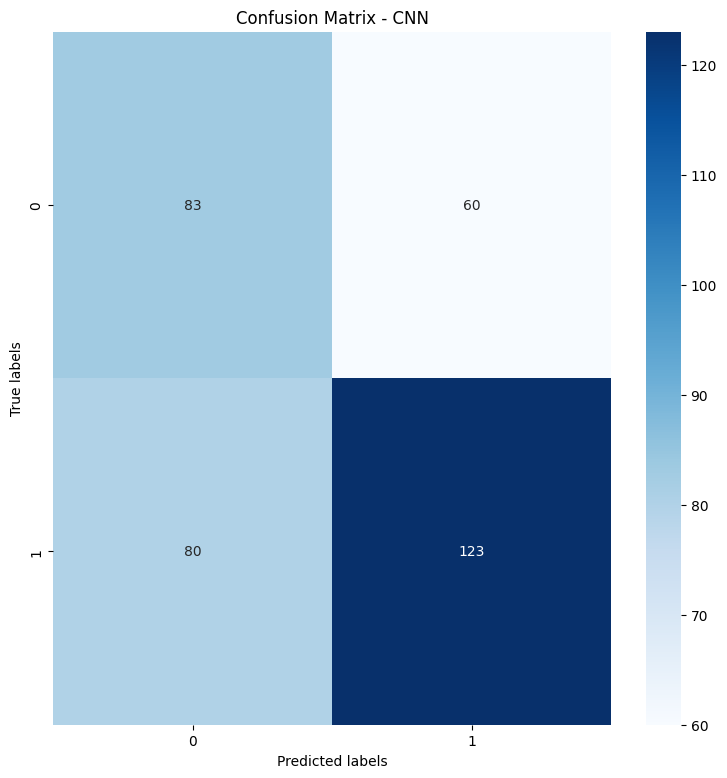

In [ ]:
# Confusion matrix
cm_cnn = metrics.confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(9, 9))
sns.heatmap(cm_cnn, annot=True, fmt="g", cmap="Blues")
# Labels, title, and ticks
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - CNN")
plt.show()

CNN Strat Return Long Only = 34.67071900844718 %
CNN Strat Return = 21.57482361269969 %
CNN Buy and Hold Return = 44.3227823398028 %


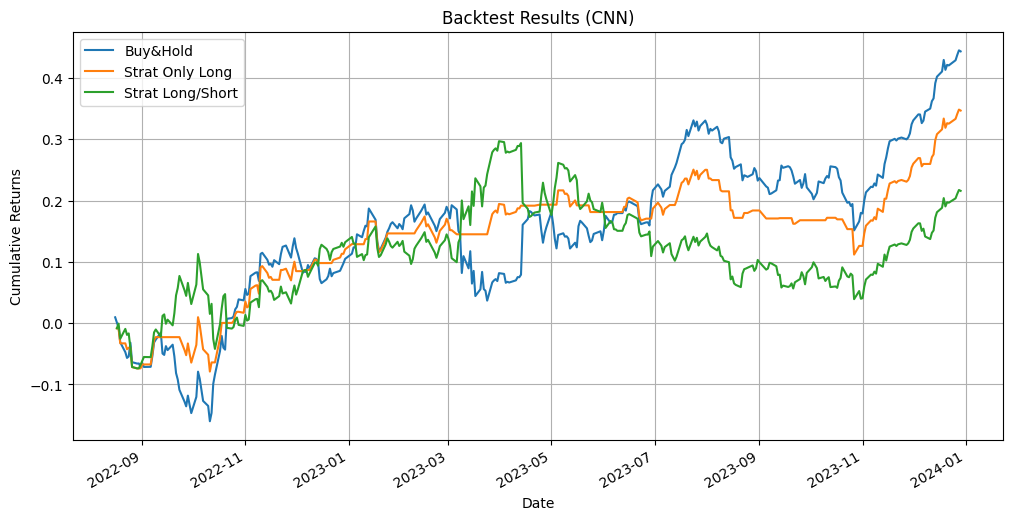

In [ ]:
# Create a DataFrame for predictions
df1_predictions_cnn = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred_cnn.flatten(),  # Predictions from model_cnn
        "Ret": Ret_vector.flatten(),
    }
)

# Define positions based on the predictions
df1_predictions_cnn["Positions"] = np.where(df1_predictions_cnn["Pred"] > 0.5, 1, -1)

# Calculate strategy returns
df1_predictions_cnn["Strat_ret"] = df1_predictions_cnn["Positions"].shift(1) * df1_predictions_cnn["Ret"]

# Long-only strategy
df1_predictions_cnn["Positions_L"] = df1_predictions_cnn["Positions"].shift(1)
df1_predictions_cnn["Positions_L"][df1_predictions_cnn["Positions_L"] == -1] = 0
df1_predictions_cnn["Strat_ret_L"] = df1_predictions_cnn["Positions_L"] * df1_predictions_cnn["Ret"]

# Calculate cumulative returns
df1_predictions_cnn["CumRet"] = df1_predictions_cnn["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df1_predictions_cnn["CumRet_L"] = df1_predictions_cnn["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df1_predictions_cnn["bhRet"] = df1_predictions_cnn["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

# Final returns for different strategies
Final_Return_L_cnn = np.prod(1 + df1_predictions_cnn["Strat_ret_L"]) - 1
Final_Return_cnn = np.prod(1 + df1_predictions_cnn["Strat_ret"]) - 1
Buy_Return_cnn = np.prod(1 + df1_predictions_cnn["Ret"]) - 1

# Print the results
print("CNN Strat Return Long Only =", Final_Return_L_cnn * 100, "%")
print("CNN Strat Return =", Final_Return_cnn * 100, "%")
print("CNN Buy and Hold Return =", Buy_Return_cnn * 100, "%")

# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df1_predictions_cnn.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df1_predictions_cnn.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df1_predictions_cnn.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtest Results (CNN)")
plt.grid()
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras import regularizers

def build_model(hp):
    model = tf.keras.models.Sequential()

    # Convolutional layers
    model.add(
        tf.keras.layers.Conv2D(
            filters=hp.Choice("filters_1", [16, 32, 64]),
            kernel_size=(3, 3),
            activation="relu",
            input_shape=(15, 15, 1),
            kernel_regularizer=regularizers.l2(hp.Float("l2_reg", 1e-4, 1e-2, sampling="log")),
        )
    )
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))

    model.add(
        tf.keras.layers.Conv2D(
            filters=hp.Choice("filters_2", [32, 64, 128]),
            kernel_size=(3, 3),
            activation="relu",
            kernel_regularizer=regularizers.l2(hp.Float("l2_reg", 1e-4, 1e-2, sampling="log")),
        )
    )
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1)))

    # Flatten and dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(
        tf.keras.layers.Dense(
            units=hp.Choice("dense_units", [32, 64, 128]),
            activation="relu",
            kernel_regularizer=regularizers.l2(hp.Float("l2_reg", 1e-4, 1e-2, sampling="log")),
        )
    )
    model.add(tf.keras.layers.Dropout(hp.Float("dropout_dense", 0.2, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [ ]:
import keras_tuner as kt

# Define a tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=50,
    factor=3,
    directory="cnn_tuning",
    project_name="stock_prediction",
)

# Search for the best hyperparameters
tuner.search(X_train_gaf, y_train, validation_split=0.2, epochs=50, batch_size=32)

# Retrieve the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of filters is {best_hps.get('filters_1')} and {best_hps.get('filters_2')}.
The optimal L2 regularization factor is {best_hps.get('l2_reg')}.
The optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_dense')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_gaf, y_train, validation_split=0.2, epochs=100, batch_size=32)


Reloading Tuner from cnn_tuning/stock_prediction/tuner0.json

The optimal number of filters is 32 and 128.
The optimal L2 regularization factor is 0.0003308300114764195.
The optimal dropout rates are 0.30000000000000004 and 0.4.
The optimal learning rate is 0.009836804915578564.

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5335 - loss: 0.8673 - val_accuracy: 0.4440 - val_loss: 0.7705
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5900 - loss: 0.7271 - val_accuracy: 0.5199 - val_loss: 0.7465
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5730 - loss: 0.7078 - val_accuracy: 0.5343 - val_loss: 0.7404
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5820 - loss: 0.7037 - val_accuracy: 0.4513 - val_loss: 0.7446
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5867 - loss: 0.6826 - val_accuracy: 0.4874 - val_loss: 0.7540
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5736 - loss: 

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test_gaf, y_test)
print(f"Test Accuracy: {test_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6018 - loss: 0.7057
Test Accuracy: 0.6127167344093323


In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Filters for the first Conv2D layer: {best_hps.get('filters_1')}
- Filters for the second Conv2D layer: {best_hps.get('filters_2')}
- L2 Regularization factor: {best_hps.get('l2_reg')}
- Dropout rate for first Conv2D layer: {best_hps.get('dropout_1')}
- Dropout rate for Dense layer: {best_hps.get('dropout_dense')}
- Units in the Dense layer: {best_hps.get('dense_units')}
- Learning rate: {best_hps.get('learning_rate')}
""")



Best Hyperparameters:
- Filters for the first Conv2D layer: 32
- Filters for the second Conv2D layer: 128
- L2 Regularization factor: 0.0003308300114764195
- Dropout rate for first Conv2D layer: 0.30000000000000004
- Dropout rate for Dense layer: 0.4
- Units in the Dense layer: 64
- Learning rate: 0.009836804915578564



In [ ]:
# Make predictions
y_prob_cnn_best = best_model.predict(X_test_gaf)
y_pred_cnn_best = np.where(y_prob_cnn_best > 0.5, 1, 0)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


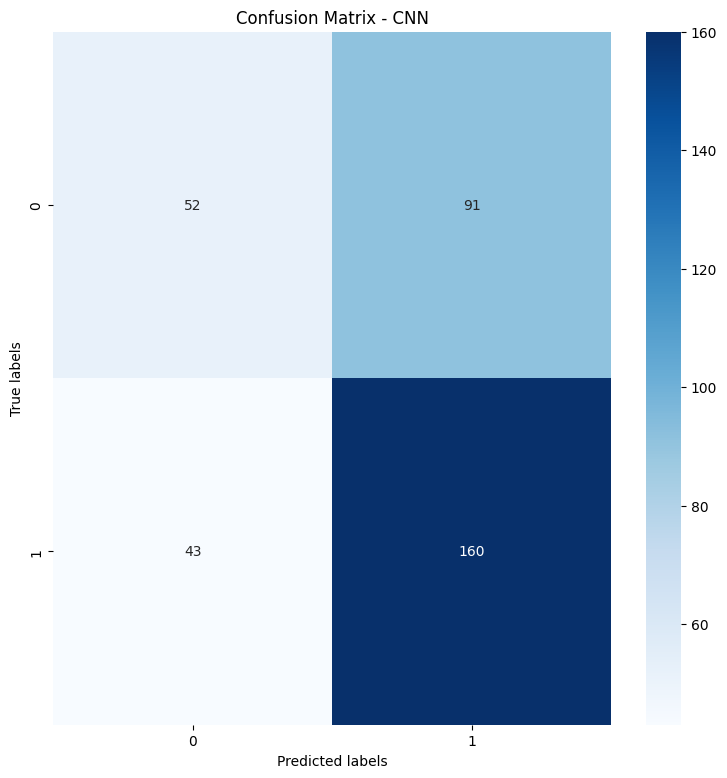

In [ ]:
# Confusion matrix
cm_cnn = metrics.confusion_matrix(y_test, y_pred_cnn_best)
plt.figure(figsize=(9, 9))
sns.heatmap(cm_cnn, annot=True, fmt="g", cmap="Blues")
# Labels, title, and ticks
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - CNN")
plt.show()

CNN Strat Return Long Only = 45.09713757171339 %
CNN Strat Return = 43.97850102262797 %
CNN Buy and Hold Return = 44.3227823398028 %


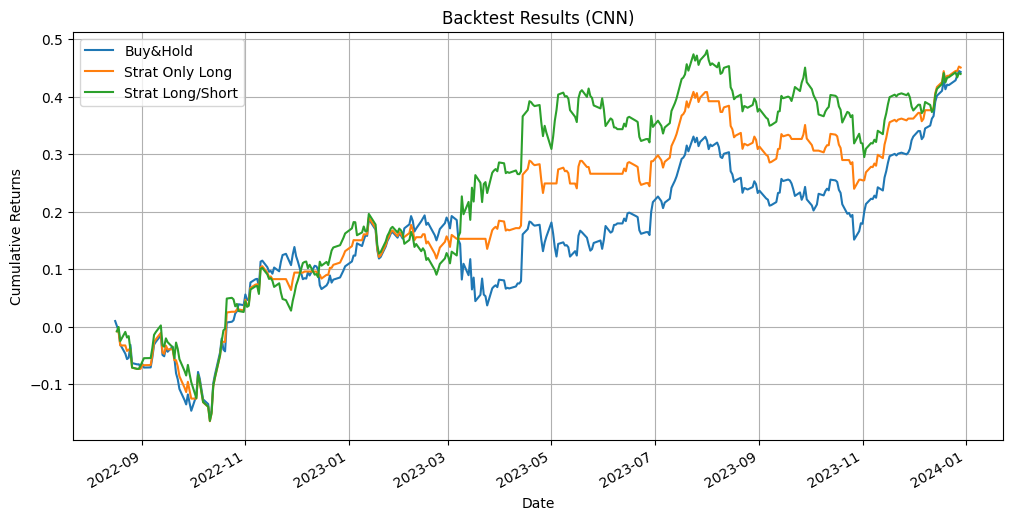

In [ ]:
# Create a DataFrame for predictions
df1_predictions_cnn = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred_cnn_best.flatten(),  # Predictions from model_cnn_best
        "Ret": Ret_vector.flatten(),
    }
)

# Define positions based on the predictions
df1_predictions_cnn["Positions"] = np.where(df1_predictions_cnn["Pred"] > 0.5, 1, -1)

# Calculate strategy returns
df1_predictions_cnn["Strat_ret"] = df1_predictions_cnn["Positions"].shift(1) * df1_predictions_cnn["Ret"]

# Long-only strategy
df1_predictions_cnn["Positions_L"] = df1_predictions_cnn["Positions"].shift(1)
df1_predictions_cnn["Positions_L"][df1_predictions_cnn["Positions_L"] == -1] = 0
df1_predictions_cnn["Strat_ret_L"] = df1_predictions_cnn["Positions_L"] * df1_predictions_cnn["Ret"]

# Calculate cumulative returns
df1_predictions_cnn["CumRet"] = df1_predictions_cnn["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df1_predictions_cnn["CumRet_L"] = df1_predictions_cnn["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df1_predictions_cnn["bhRet"] = df1_predictions_cnn["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

# Final returns for different strategies
Final_Return_L_cnn = np.prod(1 + df1_predictions_cnn["Strat_ret_L"]) - 1
Final_Return_cnn = np.prod(1 + df1_predictions_cnn["Strat_ret"]) - 1
Buy_Return_cnn = np.prod(1 + df1_predictions_cnn["Ret"]) - 1

# Print the results
print("CNN Strat Return Long Only =", Final_Return_L_cnn * 100, "%")
print("CNN Strat Return =", Final_Return_cnn * 100, "%")
print("CNN Buy and Hold Return =", Buy_Return_cnn * 100, "%")

# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df1_predictions_cnn.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df1_predictions_cnn.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df1_predictions_cnn.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtest Results (CNN)")
plt.grid()
plt.legend()
plt.show()


# Step 2

## MLP model

In [ ]:
hp_units = 30
hp_units_2 = 20
hp_units_3 = 10
n_dropout = 0.2
act_fun = "relu"

In [ ]:
# Using 500 observations for train/test split respectively
n_train = 500
n_test = 500

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df1.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df1.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],

    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: ['2019-02-11T00:00:00.000000000']  -- end test ['2021-02-03T00:00:00.000000000']  -------  (500, 15) (500,) (500, 15) (500,) (500, 1) (500, 1)
ite  1.0  -- start test: ['2021-02-04T00:00:00.000000000']  -- end test ['2023-01-30T00:00:00.000000000']  -------  (500, 15) (500,) (500, 15) (500,) (500, 1) (500, 1)
ite  2.0  -- start test: ['2023-01-31T00:00:00.000000000']  -- end test ['2023-12-29T00:00:00.000000000']  -------  (500, 15) (500,) (231, 15) (231,) (231, 1) (231, 1)


In [ ]:
df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-30-4bfc09408b43>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
<ipython-input-30-4bfc09408b43>:5: SettingWithCopyWarning: 
A value is trying to be set

Strat Return Long Only = 178.6430094510631 %
Strat Return = 176.16273211508914 %
Buy and Hold Return = 93.72810141911614 %


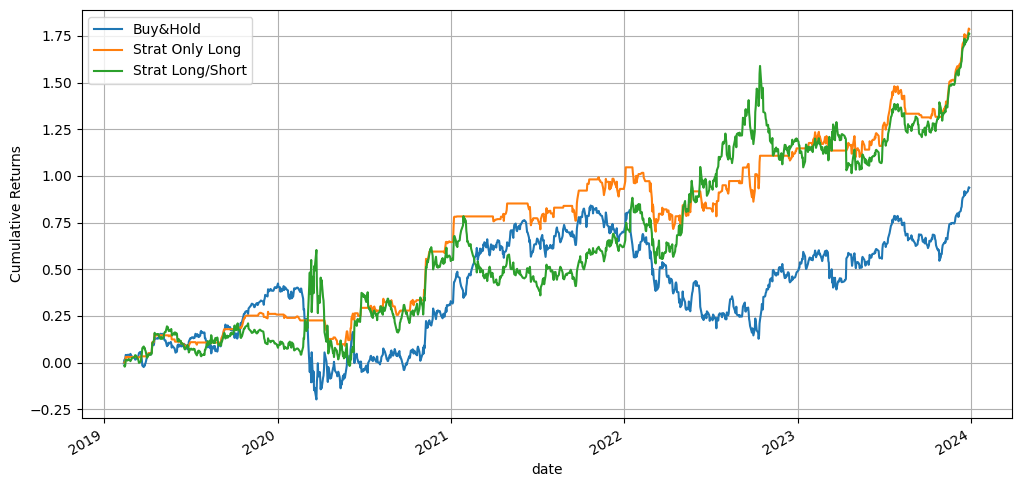

Date         Pred          Ret    Positions  \
count                           1231  1231.000000  1231.000000  1231.000000   
mean   2021-07-20 08:19:29.780666112     0.380991     0.000742    -0.238018   
min              2019-02-11 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-04-30 12:00:00     0.000000    -0.008418    -1.000000   
50%              2021-07-21 00:00:00     0.000000     0.000671    -1.000000   
75%              2022-10-08 12:00:00     1.000000     0.009765     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.485828     0.020249     0.971656   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1230.000000  1230.000000  1230.000000  1230.000000  1230.000000   
mean         -0.239024     0.001031     0.380488     0.000889     0.636791   
min          -1.000000    -0.180125     0.000000    -0.044472    -0.021744   
25%          -1.000000    -0.009017     0.000000     0.000000     0.196778   
50%          -1.000000     0.000428     0.000000     0.000000     0.542518   
75%           1.000000     0.009343     1.000000     0.000000     1.101934   
max           1.000000     0.149649     1.000000     0.135392     1.764875   
std           0.971409     0.020244     0.485704     0.010588     0.456457   

          CumRet_L        bhRet  
count  1230.000000  1231.000000  
mean      0.715215     0.389394  
min       0.000000    -0.197317  
25%       0.251534     0.145662  
50%       0.797296     0.403959  
75%       1.046095     0.624588  
max       1.789707     0.939559  
std       0.438574     0.265576

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

In [ ]:
# Using 500/100 observations for train/test split respectively
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df1.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df1.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],

    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: ['2019-02-11T00:00:00.000000000']  -- end test ['2019-07-03T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)


ite  1.0  -- start test: ['2019-07-05T00:00:00.000000000']  -- end test ['2019-11-22T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)


ite  2.0  -- start test: ['2019-11-25T00:00:00.000000000']  -- end test ['2020-04-20T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)
ite  3.0  -- start test: ['2020-04-21T00:00:00.000000000']  -- end test ['2020-09-10T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)
ite  4.0  -- start test: ['2020-09-11T00:00:00.000000000']  -- end test ['2021-02-03T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)
ite  5.0  -- start test: ['2021-02-04T00:00:00.000000000']  -- end test ['2021-06-28T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)
ite  6.0  -- start test: ['2021-06-29T00:00:00.000000000']  -- end test ['2021-11-17T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (100, 1)
ite  7.0  -- start test: ['2021-11-18T00:00:00.000000000']  -- end test ['2022-04-12T00:00:00.000000000']  -------  (500, 15) (500,) (100, 15) (100,) (100, 1) (

In [ ]:
df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-27-4bfc09408b43>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
<ipython-input-27-4bfc09408b43>:5: SettingWithCopyWarning: 
A value is trying to be set

Strat Return Long Only = 188.3687844426842 %
Strat Return = 242.4370592707692 %
Buy and Hold Return = 93.72810141911614 %


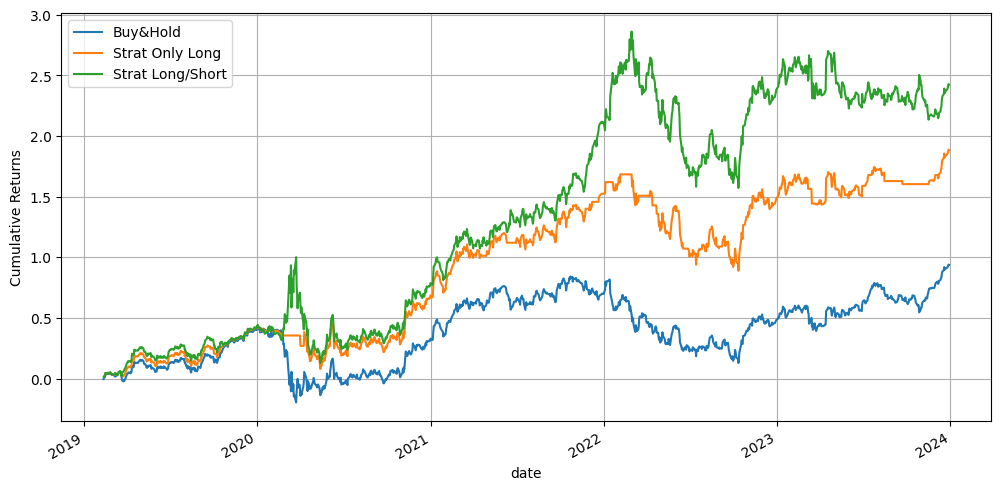

Date         Pred          Ret    Positions  \
count                           1231  1231.000000  1231.000000  1231.000000   
mean   2021-07-20 08:19:29.780666112     0.773355     0.000742     0.546710   
min              2019-02-11 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-04-30 12:00:00     1.000000    -0.008418     1.000000   
50%              2021-07-21 00:00:00     1.000000     0.000671     1.000000   
75%              2022-10-08 12:00:00     1.000000     0.009765     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.418831     0.020249     0.837662   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1230.000000  1230.000000  1230.000000  1230.000000  1230.000000   
mean          0.546341     0.001206     0.773171     0.000976     1.329949   
min          -1.000000    -0.180125     0.000000    -0.083443     0.015266   
25%           1.000000    -0.008343     1.000000    -0.005291     0.362157   
50%           1.000000     0.000621     1.000000     0.000000     1.331026   
75%           1.000000     0.009923     1.000000     0.006601     2.288402   
max           1.000000     0.149649     1.000000     0.135392     2.861865   
std           0.837903     0.020234     0.418952     0.015199     0.896068   

          CumRet_L        bhRet  
count  1230.000000  1231.000000  
mean      0.939557     0.389394  
min       0.015266    -0.197317  
25%       0.317958     0.145662  
50%       1.086377     0.403959  
75%       1.495103     0.624588  
max       1.887079     0.939559  
std       0.575377     0.265576

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

## LSTM model

In [ ]:
hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"

In [ ]:
n_train = 500
n_test = 500

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    # Split data into train and test sets
    X_train, X_test = X[i : i + n_train].values, X[i + n_train : i + n_train + n_test].values
    y_train, y_test = y[i : i + n_train].values, y[i + n_train : i + n_train + n_test].values
    test_time = df2.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df2.iloc[i + n_train : i + n_train + n_test, 1:2].values

    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    # Reshape input data for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1))

    # Clear session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # Define LSTM model
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            units=50, return_sequences=True, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=False, activation="tanh"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile model
    adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    # Define class weights
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    # Predict on test set
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    # Append results
    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

ite  0.0  -- start test: ['2018-12-31T00:00:00.000000000']  -- end test ['2020-12-22T00:00:00.000000000']  -------  (500, 1) (500,) (500, 1) (500,) (500, 1) (500, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ite  1.0  -- start test: ['2020-12-23T00:00:00.000000000']  -- end test ['2022-12-16T00:00:00.000000000']  -------  (500, 1) (500,) (500, 1) (500,) (500, 1) (500, 1)
ite  2.0  -- start test: ['2022-12-19T00:00:00.000000000']  -- end test ['2023-12-21T00:00:00.000000000']  -------  (500, 1) (500,) (254, 1) (254,) (254, 1) (254, 1)


In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res.head()

Date  Pred LSTM           Ret  Positions     Strat_ret        CumRet  \
0 2021-06-25   0.000015  1.861052e-04        1.0           NaN           NaN   
1 2021-06-28   0.000020 -2.040383e-08        1.0 -2.040383e-08 -2.040383e-08   
2 2021-06-29   0.000023  2.402564e-05        1.0  2.402564e-05  2.400524e-05   
3 2021-06-30   0.000024 -2.393220e-04        1.0 -2.393220e-04 -2.153225e-04   
4 2021-07-01   0.000023 -1.841028e-05        1.0 -1.841028e-05 -2.337288e-04   

      bhRet  Positions_L   Strat_ret_L      CumRet_L  
0  0.000186          NaN           NaN           NaN  
1  0.000186          1.0 -2.040383e-08 -2.040383e-08  
2  0.000210          1.0  2.402564e-05  2.400524e-05  
3 -0.000029          1.0 -2.393220e-04 -2.153225e-04  
4 -0.000048          1.0 -1.841028e-05 -2.337288e-04

In [ ]:
df_res["Positions"] = np.where(df_res["Ret"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-160-0c5a439c1792>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
<ipython-input-160-0c5a439c1792>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Strat Return Long Only = 0.0 %
Strat Return = -1.157400858737978 %
Buy and Hold Return = 1.1810541152954102 %


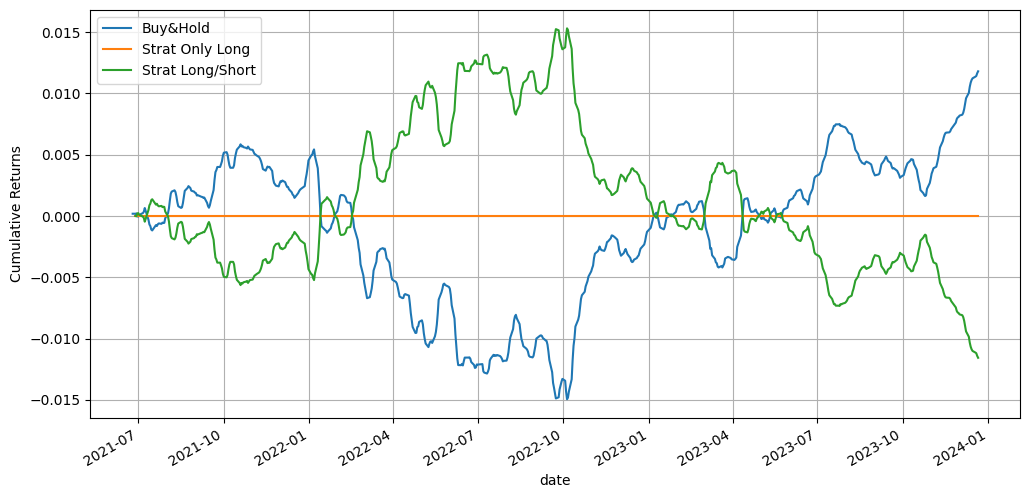

Date   Pred LSTM         Ret  Positions  \
count                            628  628.000000  628.000000      628.0   
mean   2022-09-23 04:12:13.757961728    0.000014    0.000019       -1.0   
min              2021-06-25 00:00:00   -0.000028   -0.001448       -1.0   
25%              2022-02-07 18:00:00    0.000007   -0.000183       -1.0   
50%              2022-09-22 12:00:00    0.000014    0.000039       -1.0   
75%              2023-05-09 06:00:00    0.000022    0.000245       -1.0   
max              2023-12-21 00:00:00    0.000039    0.001562       -1.0   
std                              NaN    0.000011    0.000369        0.0   

        Strat_ret      CumRet       bhRet  Positions_L  Strat_ret_L  CumRet_L  \
count  627.000000  627.000000  628.000000        627.0        627.0     627.0   
mean    -0.000018    0.001281   -0.001103          0.0          0.0       0.0   
min     -0.001562   -0.011574   -0.014957          0.0          0.0       0.0   
25%     -0.000246   -0.003261   -0.004604          0.0          0.0       0.0   
50%     -0.000039   -0.000130    0.000241          0.0          0.0       0.0   
75%      0.000184    0.004853    0.003393          0.0         -0.0       0.0   
max      0.001448    0.015319    0.011811          0.0          0.0       0.0   
std      0.000369    0.005990    0.005949          0.0          0.0       0.0   

       Positions_shift  trade_bin  
count            627.0      627.0  
mean              -1.0        0.0  
min               -1.0        0.0  
25%               -1.0        0.0  
50%               -1.0        0.0  
75%               -1.0        0.0  
max               -1.0        0.0  
std                0.0        0.0

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df_res["trade_bin"] = df_res["Positions"].diff().abs()
df_res["trade_bin"] = df_res["trade_bin"] / 2
df_res.describe()

In [ ]:
hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"

In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    # Split data into train and test sets
    X_train, X_test = X[i : i + n_train].values, X[i + n_train : i + n_train + n_test].values
    y_train, y_test = y[i : i + n_train].values, y[i + n_train : i + n_train + n_test].values
    test_time = df2.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df2.iloc[i + n_train : i + n_train + n_test, 1:2].values

    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    # Reshape input data for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1))

    # Clear session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # Define LSTM model
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            units=50, return_sequences=True, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=False, activation="tanh"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile model
    adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    # Define class weights
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    # Predict on test set
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    # Append results
    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

ite  0.0  -- start test: ['2018-12-31T00:00:00.000000000']  -- end test ['2019-05-23T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ite  1.0  -- start test: ['2019-05-24T00:00:00.000000000']  -- end test ['2019-10-15T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)
ite  2.0  -- start test: ['2019-10-16T00:00:00.000000000']  -- end test ['2020-03-10T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)
ite  3.0  -- start test: ['2020-03-11T00:00:00.000000000']  -- end test ['2020-07-31T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)
ite  4.0  -- start test: ['2020-08-03T00:00:00.000000000']  -- end test ['2020-12-22T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)
ite  5.0  -- start test: ['2020-12-23T00:00:00.000000000']  -- end test ['2021-05-18T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)
ite  6.0  -- start test: ['2021-05-19T00:00:00.000000000']  -- end test ['2021-10-08T00:00:00.000000000']  -------  (500, 1) (500,) (100, 1) (100,) (100, 1) (100, 1)
ite 

In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res.head()

Date     Pred LSTM           Ret  Positions     Strat_ret  \
0 2021-06-25  3.635331e-07  1.861052e-04        1.0           NaN   
1 2021-06-28  3.814361e-06 -2.040383e-08        1.0 -2.040383e-08   
2 2021-06-29  6.119959e-06  2.402564e-05        1.0  2.402564e-05   
3 2021-06-30  7.215391e-06 -2.393220e-04        1.0 -2.393220e-04   
4 2021-07-01  6.680572e-06 -1.841028e-05        1.0 -1.841028e-05   

         CumRet     bhRet  Positions_L   Strat_ret_L      CumRet_L  
0           NaN  0.000186          NaN           NaN           NaN  
1 -2.040383e-08  0.000186          1.0 -2.040383e-08 -2.040383e-08  
2  2.400524e-05  0.000210          1.0  2.402564e-05  2.400524e-05  
3 -2.153225e-04 -0.000029          1.0 -2.393220e-04 -2.153225e-04  
4 -2.337288e-04 -0.000048          1.0 -1.841028e-05 -2.337288e-04

In [ ]:
df_res["Positions"] = np.where(df_res["Ret"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-185-0c5a439c1792>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
<ipython-input-185-0c5a439c1792>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Strat Return Long Only = 0.0 %
Strat Return = -1.157400858737978 %
Buy and Hold Return = 1.1810541152954102 %


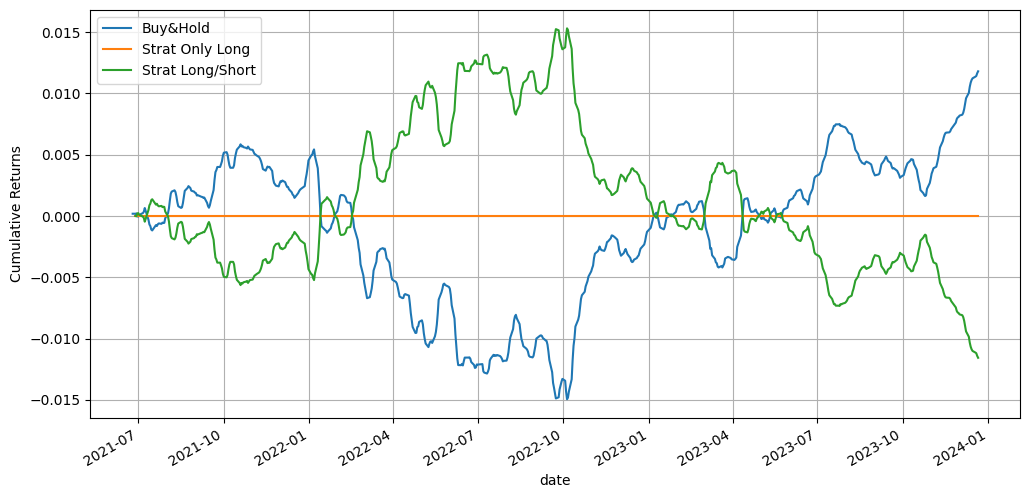

Date   Pred LSTM         Ret  Positions  \
count                            628  628.000000  628.000000      628.0   
mean   2022-09-23 04:12:13.757961728   -0.000006    0.000019       -1.0   
min              2021-06-25 00:00:00   -0.000039   -0.001448       -1.0   
25%              2022-02-07 18:00:00   -0.000012   -0.000183       -1.0   
50%              2022-09-22 12:00:00   -0.000005    0.000039       -1.0   
75%              2023-05-09 06:00:00    0.000002    0.000245       -1.0   
max              2023-12-21 00:00:00    0.000019    0.001562       -1.0   
std                              NaN    0.000010    0.000369        0.0   

        Strat_ret      CumRet       bhRet  Positions_L  Strat_ret_L  CumRet_L  \
count  627.000000  627.000000  628.000000        627.0        627.0     627.0   
mean    -0.000018    0.001281   -0.001103          0.0          0.0       0.0   
min     -0.001562   -0.011574   -0.014957          0.0          0.0       0.0   
25%     -0.000246   -0.003261   -0.004604          0.0          0.0       0.0   
50%     -0.000039   -0.000130    0.000241          0.0          0.0       0.0   
75%      0.000184    0.004853    0.003393          0.0         -0.0       0.0   
max      0.001448    0.015319    0.011811          0.0          0.0       0.0   
std      0.000369    0.005990    0.005949          0.0          0.0       0.0   

       Positions_shift  trade_bin  
count            627.0      627.0  
mean              -1.0        0.0  
min               -1.0        0.0  
25%               -1.0        0.0  
50%               -1.0        0.0  
75%               -1.0        0.0  
max               -1.0        0.0  
std                0.0        0.0

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df_res["trade_bin"] = df_res["Positions"].diff().abs()
df_res["trade_bin"] = df_res["trade_bin"] / 2
df_res.describe()

## CNN model

In [ ]:
# Best Hyperparameters from HPO
hp_filters_1 = 32  # Filters for first Conv2D layer
hp_filters_2 = 128  # Filters for second Conv2D layer
hp_l2_reg = 0.0003308300114764195  # L2 regularization factor
n_dropout_1 = 0.3  # Dropout rate for the first Conv2D layer
n_dropout_dense = 0.4  # Dropout rate for Dense layer
hp_units_dense = 64  # Units in Dense layer
hp_lr = 0.009836804915578564  # Learning rate

In [ ]:
# Using 500 observations for train/test split respectively
n_train = 500
n_test = 500

In [ ]:
time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []


In [ ]:
# Initialize the GAF transformer
gaf = GramianAngularField(image_size=15 , method="summation")

# Convert the returns column into GAF images
X_gaf = gaf.fit_transform(X)  # X contains the lagged features
X_gaf = np.expand_dims(X_gaf, axis=-1)  # Add channel dimension for CNN

In [ ]:
# Iterate through the dataset and backtest the CNN model
for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X_gaf[i : i + n_train], X_gaf[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + n_train], y[i + n_train : i + n_train + n_test]
    test_time = df1.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df1.iloc[i + n_train : i + n_train + n_test, 1:2].values
    print(f"ite {i / n_test} -- start test: {test_time[0]} -- end test {test_time[-1]}")

    # Clear previous session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)



    # Build CNN model with GAP and L2 Regularization
    model = tf.keras.models.Sequential()

    # First Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_1,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=X_train.shape[1:],
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(n_dropout_1))  # Dropout after first Conv2D layer

    # Second Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_2,
        kernel_size=(3, 3),
        activation="relu",
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (GAP)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dropout before Dense layer
    model.add(tf.keras.layers.Dropout(n_dropout_dense))

    # Fully connected output layer with 64 units
    model.add(tf.keras.layers.Dense(units=hp_units_dense, activation="relu"))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model with the best learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    # Predict and store results
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())


ite 0.0 -- start test: ['2019-02-11T00:00:00.000000000'] -- end test ['2021-02-03T00:00:00.000000000']
ite 1.0 -- start test: ['2021-02-04T00:00:00.000000000'] -- end test ['2023-01-30T00:00:00.000000000']
ite 2.0 -- start test: ['2023-01-31T00:00:00.000000000'] -- end test ['2023-12-29T00:00:00.000000000']


Strat Return Long Only = 63.71597890834102 %
Strat Return = 22.77498830123179 %
Buy and Hold Return = 93.72810197710501 %


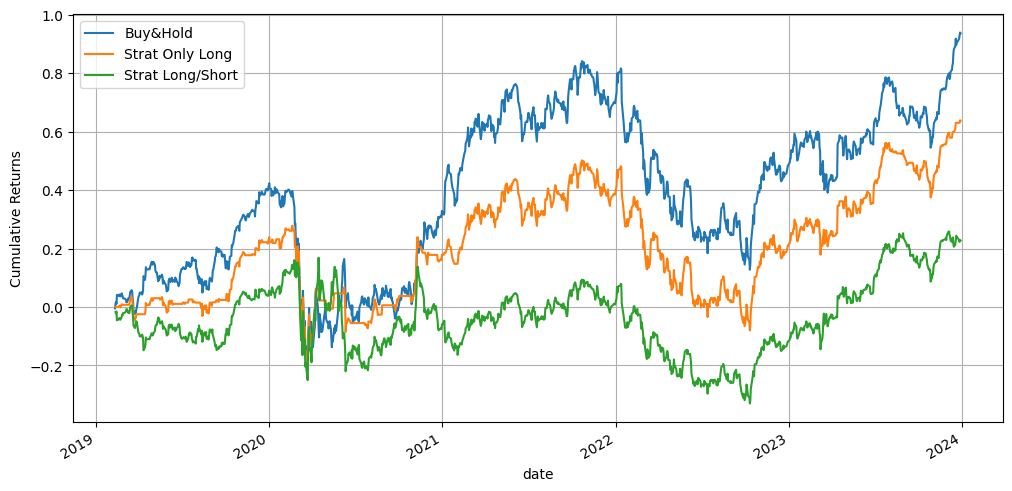

Date         Pred          Ret    Positions  \
count                           1231  1231.000000  1231.000000  1231.000000   
mean   2021-07-20 08:19:29.780666112     0.749797     0.000742     0.499594   
min              2019-02-11 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-04-30 12:00:00     0.500000    -0.008418     0.000000   
50%              2021-07-21 00:00:00     1.000000     0.000671     1.000000   
75%              2022-10-08 12:00:00     1.000000     0.009765     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.433306     0.020249     0.866612   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1230.000000  1230.000000  1230.000000  1230.000000  1230.000000   
mean          0.499187     0.000372     0.749593     0.000559    -0.037486   
min          -1.000000    -0.149649     0.000000    -0.149649    -0.330073   
25%          -0.500000    -0.008377     0.250000    -0.004842    -0.116021   
50%           1.000000     0.000274     1.000000    -0.000000    -0.044385   
75%           1.000000     0.009879     1.000000     0.006296     0.039520   
max           1.000000     0.180125     1.000000     0.180125     0.258406   
std           0.866847     0.020267     0.433423     0.017814     0.121800   

          CumRet_L        bhRet  
count  1230.000000  1231.000000  
mean      0.204979     0.389394  
min      -0.214648    -0.197317  
25%       0.024236     0.145662  
50%       0.200008     0.403959  
75%       0.350213     0.624588  
max       0.639085     0.939559  
std       0.183010     0.265575

In [ ]:
df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

In [ ]:
# Using 500/100 observations for train/test split respectively
n_train = 500
n_test = 100

In [ ]:
time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []


In [ ]:
# Initialize the GAF transformer
gaf = GramianAngularField(image_size=15 , method="summation")

# Convert the returns column into GAF images
X_gaf = gaf.fit_transform(X)  # X contains the lagged features
X_gaf = np.expand_dims(X_gaf, axis=-1)  # Add channel dimension for CNN

In [ ]:
# Iterate through the dataset and backtest the CNN model
for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X_gaf[i : i + n_train], X_gaf[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + n_train], y[i + n_train : i + n_train + n_test]
    test_time = df1.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df1.iloc[i + n_train : i + n_train + n_test, 1:2].values
    print(f"ite {i / n_test} -- start test: {test_time[0]} -- end test {test_time[-1]}")

    # Clear previous session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)



    # Build CNN model with GAP and L2 Regularization
    model = tf.keras.models.Sequential()

    # First Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_1,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=X_train.shape[1:],
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(n_dropout_1))  # Dropout after first Conv2D layer

    # Second Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_2,
        kernel_size=(3, 3),
        activation="relu",
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (GAP)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dropout before Dense layer
    model.add(tf.keras.layers.Dropout(n_dropout_dense))

    # Fully connected output layer with 64 units
    model.add(tf.keras.layers.Dense(units=hp_units_dense, activation="relu"))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model with the best learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    # Predict and store results
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())


ite 0.0 -- start test: ['2019-02-11T00:00:00.000000000'] -- end test ['2019-07-03T00:00:00.000000000']


ite 1.0 -- start test: ['2019-07-05T00:00:00.000000000'] -- end test ['2019-11-22T00:00:00.000000000']


ite 2.0 -- start test: ['2019-11-25T00:00:00.000000000'] -- end test ['2020-04-20T00:00:00.000000000']
ite 3.0 -- start test: ['2020-04-21T00:00:00.000000000'] -- end test ['2020-09-10T00:00:00.000000000']
ite 4.0 -- start test: ['2020-09-11T00:00:00.000000000'] -- end test ['2021-02-03T00:00:00.000000000']
ite 5.0 -- start test: ['2021-02-04T00:00:00.000000000'] -- end test ['2021-06-28T00:00:00.000000000']
ite 6.0 -- start test: ['2021-06-29T00:00:00.000000000'] -- end test ['2021-11-17T00:00:00.000000000']
ite 7.0 -- start test: ['2021-11-18T00:00:00.000000000'] -- end test ['2022-04-12T00:00:00.000000000']
ite 8.0 -- start test: ['2022-04-13T00:00:00.000000000'] -- end test ['2022-09-06T00:00:00.000000000']
ite 9.0 -- start test: ['2022-09-07T00:00:00.000000000'] -- end test ['2023-01-30T00:00:00.000000000']
ite 10.0 -- start test: ['2023-01-31T00:00:00.000000000'] -- end test ['2023-06-23T00:00:00.000000000']
ite 11.0 -- start test: ['2023-06-26T00:00:00.000000000'] -- end test ['

Strat Return Long Only = 73.02394852344563 %
Strat Return = 44.22722454467907 %
Buy and Hold Return = 93.72810197710501 %


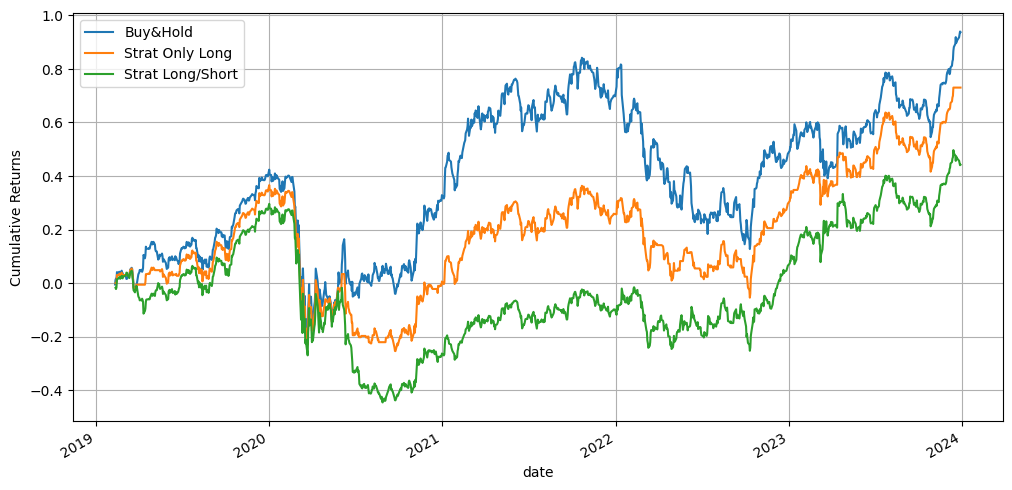

Date         Pred          Ret    Positions  \
count                           1231  1231.000000  1231.000000  1231.000000   
mean   2021-07-20 08:19:29.780666112     0.838343     0.000742     0.676686   
min              2019-02-11 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-04-30 12:00:00     1.000000    -0.008418     1.000000   
50%              2021-07-21 00:00:00     1.000000     0.000671     1.000000   
75%              2022-10-08 12:00:00     1.000000     0.009765     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.368286     0.020249     0.736571   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1230.000000  1230.000000  1230.000000  1230.000000  1230.000000   
mean          0.678049     0.000503     0.839024     0.000624    -0.023288   
min          -1.000000    -0.149649     0.000000    -0.149649    -0.444997   
25%           1.000000    -0.008499     1.000000    -0.006388    -0.150601   
50%           1.000000     0.000784     1.000000     0.000000    -0.066477   
75%           1.000000     0.009678     1.000000     0.007737     0.160675   
max           1.000000     0.180125     1.000000     0.180125     0.496806   
std           0.735316     0.020264     0.367658     0.018927     0.208341   

          CumRet_L        bhRet  
count  1230.000000  1231.000000  
mean      0.181330     0.389394  
min      -0.253452    -0.197317  
25%       0.034673     0.145662  
50%       0.181969     0.403959  
75%       0.324105     0.624588  
max       0.730239     0.939559  
std       0.213283     0.265575

In [ ]:
df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

# Step 3

## MLP model

In [ ]:
df2 = df["Adj Close"]
df2["Ret"] = df2["JPM"].pct_change()
df2 = df2.reset_index()
df2.dropna(inplace=True)
df2.drop(columns=["JPM"], inplace=True)

In [ ]:
# Create features using different lags
n_lags = 30

for i in range(1, n_lags + 1, 2):
    name = "Ret_" + str(i)
    df2[name] = df2["Ret"].rolling(i).apply(lambda x: (np.prod(1 + x) - 1))

In [ ]:
# Use labels that try to avoid leakage of information between training and test samples. In this case, there is a gap of 10 days
# between the end of training data and the data used for the test data.
df2["Ret10_i"] = df2["Ret"].rolling(10).apply(lambda x: (np.prod(1 + x) - 1))
df2["Ret20"] = df2["Ret10_i"].shift(-20)
df2["Output"] = df2["Ret20"] > 0
df2["Output"] = df2["Output"].astype(int)
del df2["Ret20"]
del df2["Ret10_i"]
df2 = df2.dropna()

In [ ]:
# Split the timing for test sample, 20% for test sample
ts = int(0.2 * len(df2))
split_time = len(df2) - ts
test_time = df2.iloc[split_time:, 0:1].values
Ret_vector = df2.iloc[split_time:, 1:2].values

In [ ]:
# Perform train-test split
Xdf, ydf = df2.iloc[:, 2:-1], df2.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=False
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1408, 14) (351, 14) (1408,) (351,)


In [ ]:
hp_units = 30
hp_units_2 = 20
hp_units_3 = 10
n_dropout = 0.2
act_fun = "relu"

In [ ]:
# Using 500 observations for train/test split respectively
n_train = 500
n_test = 500

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df2.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df2.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],

    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: ['2018-12-31T00:00:00.000000000']  -- end test ['2020-12-22T00:00:00.000000000']  -------  (500, 14) (500,) (500, 14) (500,) (500, 1) (500, 1)
ite  1.0  -- start test: ['2020-12-23T00:00:00.000000000']  -- end test ['2022-12-16T00:00:00.000000000']  -------  (500, 14) (500,) (500, 14) (500,) (500, 1) (500, 1)
ite  2.0  -- start test: ['2022-12-19T00:00:00.000000000']  -- end test ['2023-12-29T00:00:00.000000000']  -------  (500, 14) (500,) (259, 14) (259,) (259, 1) (259, 1)


In [ ]:
df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Strat Return Long Only = 35.304754253282496 %
Strat Return = -38.04889625053135 %
Buy and Hold Return = 104.43809572987455 %


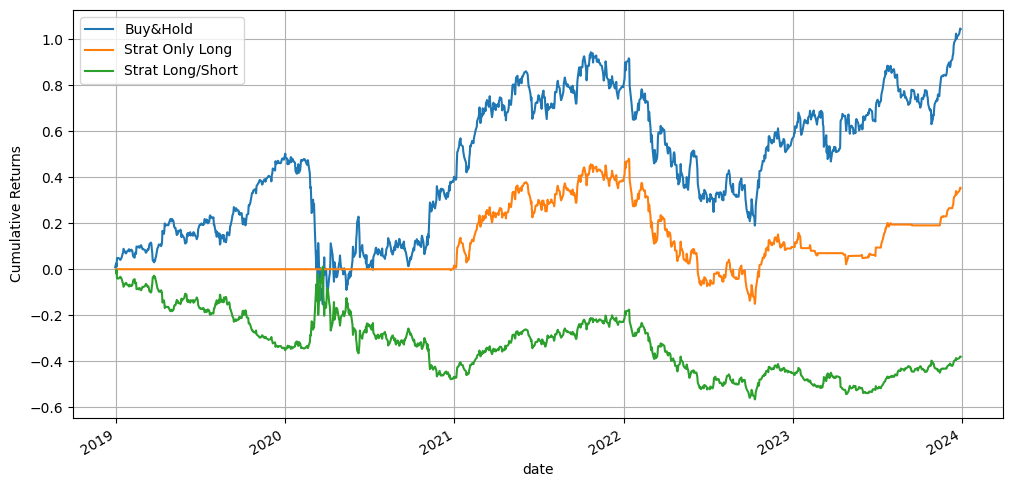

Date         Pred          Ret    Positions  \
count                           1259  1259.000000  1259.000000  1259.000000   
mean   2021-06-30 01:24:38.316123904     0.436060     0.000769    -0.127879   
min              2018-12-31 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-03-31 12:00:00     0.000000    -0.008398    -1.000000   
50%              2021-06-30 00:00:00     0.000000     0.000695    -1.000000   
75%              2022-09-28 12:00:00     1.000000     0.009654     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.496092     0.020084     0.992184   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean         -0.128776    -0.000177     0.435612     0.000293    -0.330332   
min          -1.000000    -0.180125     0.000000    -0.061463    -0.566226   
25%          -1.000000    -0.008939     0.000000     0.000000    -0.444174   
50%          -1.000000    -0.000435     0.000000     0.000000    -0.332034   
75%           1.000000     0.009073     1.000000     0.000000    -0.233960   
max           1.000000     0.149649     1.000000     0.055593     0.010925   
std           0.992068     0.020105     0.496034     0.010289     0.132107   

          CumRet_L        bhRet  
count  1258.000000  1259.000000  
mean      0.105229     0.457205  
min      -0.150612    -0.152942  
25%       0.000000     0.193179  
50%       0.048883     0.473322  
75%       0.194200     0.706703  
max       0.480024     1.046785  
std       0.139361     0.283496

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

In [ ]:
# Using 500/100 observations for train/test split respectively
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df2.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df2.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],

    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: ['2018-12-31T00:00:00.000000000']  -- end test ['2019-05-23T00:00:00.000000000']  -------  (500, 14) (500,) (100, 14) (100,) (100, 1) (100, 1)
ite  1.0  -- start test: ['2019-05-24T00:00:00.000000000']  -- end test ['2019-10-15T00:00:00.000000000']  -------  (500, 14) (500,) (100, 14) (100,) (100, 1) (100, 1)
ite  2.0  -- start test: ['2019-10-16T00:00:00.000000000']  -- end test ['2020-03-10T00:00:00.000000000']  -------  (500, 14) (500,) (100, 14) (100,) (100, 1) (100, 1)
ite  3.0  -- start test: ['2020-03-11T00:00:00.000000000']  -- end test ['2020-07-31T00:00:00.000000000']  -------  (500, 14) (500,) (100, 14) (100,) (100, 1) (100, 1)
ite  4.0  -- start test: ['2020-08-03T00:00:00.000000000']  -- end test ['2020-12-22T00:00:00.000000000']  -------  (500, 14) (500,) (100, 14) (100,) (100, 1) (100, 1)
ite  5.0  -- start test: ['2020-12-23T00:00:00.000000000']  -- end test ['2021-05-18T00:00:00.000000000']  -------  (500, 14) (500,) (100, 14) (100,) (100, 1) (

In [ ]:
df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Strat Return Long Only = 43.10895188830226 %
Strat Return = -24.0050478111275 %
Buy and Hold Return = 104.43809572987455 %


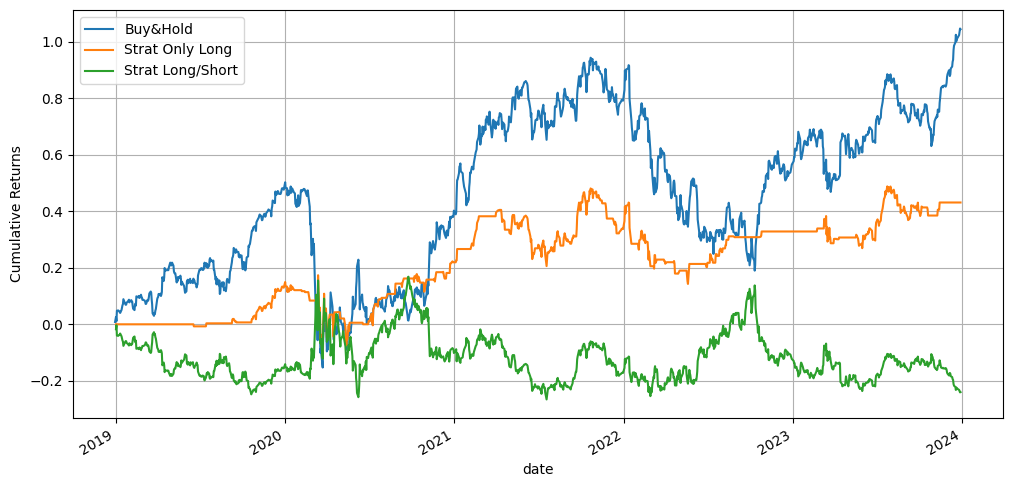

Date         Pred          Ret    Positions  \
count                           1259  1259.000000  1259.000000  1259.000000   
mean   2021-06-30 01:24:38.316123904     0.379666     0.000769    -0.240667   
min              2018-12-31 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-03-31 12:00:00     0.000000    -0.008398    -1.000000   
50%              2021-06-30 00:00:00     0.000000     0.000695    -1.000000   
75%              2022-09-28 12:00:00     1.000000     0.009654     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.485497     0.020084     0.970993   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean         -0.240064    -0.000016     0.379968     0.000374    -0.120985   
min          -1.000000    -0.149649     0.000000    -0.149649    -0.265871   
25%          -1.000000    -0.008898     0.000000     0.000000    -0.179792   
50%          -1.000000     0.000089     0.000000     0.000000    -0.135829   
75%           1.000000     0.009378     1.000000    -0.000000    -0.075913   
max           1.000000     0.180125     1.000000     0.180125     0.168387   
std           0.971143     0.020106     0.485572     0.013352     0.079026   

          CumRet_L        bhRet  
count  1258.000000  1259.000000  
mean      0.218311     0.457205  
min      -0.107321    -0.152942  
25%       0.072118     0.193179  
50%       0.258675     0.473322  
75%       0.328493     0.706703  
max       0.488049     1.046785  
std       0.151294     0.283496

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

## LSTM model

In [ ]:
# Step 1: Calculate future returns and align them
df2 = df[["Date", "Ret"]].copy()
df2["Ret_10"] = df2["Ret"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df2["Ret10"] = df2["Ret_10"].shift(-10)
df2.drop(columns=["Ret_5"], inplace=True)
df2 = df2.dropna()

# Step 2: Ensure no overlap between training and test sets
# This is enforced in the walk-forward logic in subsequent steps.

In [ ]:
## Introduce leakage: Calculate future 5-day returns for JPM
df2 = df[["Date", "Ret"]]
df2["Ret_5"] = df2["Ret"].rolling(5).apply(lambda x: np.prod(1 + x / 100) - 1)
df2["Ret5"] = df2["Ret_5"].shift(-5)
del df2["Ret_5"]
df2 = df2.dropna()
df2.head()

# Define Train, val, test samples

Xdf, ydf = df2.iloc[:, 1:-1], df2.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")


## define the validation, train, and test samples

val_split = 0.2
train_split = 0.625
train_size = int(len(df2) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df2) - train_size)

window_size = 30

ts = test_size
split_time = len(df2) - ts
test_time = df2.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]


## Scale data

scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)


# Split data

training_time = df2.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)


hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"

n_train = 500
n_test = 500

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    # Split data into train and test sets
    X_train, X_test = X[i : i + n_train].values, X[i + n_train : i + n_train + n_test].values
    y_train, y_test = y[i : i + n_train].values, y[i + n_train : i + n_train + n_test].values
    test_time = df2.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df2.iloc[i + n_train : i + n_train + n_test, 1:2].values

    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    # Reshape input data for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1))

    # Clear session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # Define LSTM model
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            units=50, return_sequences=True, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=False, activation="tanh"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile model
    adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    # Define class weights
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    # Predict on test set
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    # Append results
    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions


df_res["Positions"] = np.where(df_res["Ret"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Shape of training data (1066, 30, 1) (1066, 1)
Shape of test data (628, 30, 1) (658, 1)
ite  0.0  -- start test: ['2018-12-31T00:00:00.000000000']  -- end test ['2020-12-22T00:00:00.000000000']  -------  (500, 1) (500,) (500, 1) (500,) (500, 1) (500, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ite  1.0  -- start test: ['2020-12-23T00:00:00.000000000']  -- end test ['2022-12-16T00:00:00.000000000']  -------  (500, 1) (500,) (500, 1) (500,) (500, 1) (500, 1)
ite  2.0  -- start test: ['2022-12-19T00:00:00.000000000']  -- end test ['2023-12-21T00:00:00.000000000']  -------  (500, 1) (500,) (254, 1) (254,) (254, 1) (254, 1)


<ipython-input-44-1715a6edd338>:186: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
<ipython-input-44-1715a6edd338>:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Strat Return Long Only = 0.0 %
Strat Return = -1.157401326302987 %
Buy and Hold Return = 1.181018352508545 %


In [ ]:
n_train = 500
n_test = 500

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    # Split data into train and test sets
    X_train, X_test = X[i : i + n_train].values, X[i + n_train : i + n_train + n_test].values
    y_train, y_test = y[i : i + n_train].values, y[i + n_train : i + n_train + n_test].values
    test_time = df2.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df2.iloc[i + n_train : i + n_train + n_test, 1:2].values

    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    # Reshape input data for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1))

    # Clear session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # Define LSTM model
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            units=50, return_sequences=True, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=False, activation="tanh"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile model
    adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )

    # Define class weights
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    # Predict on test set
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    # Append results
    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions


df_res["Positions"] = np.where(df_res["Ret"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

ite  0.0  -- start test: ['2018-12-31T00:00:00.000000000']  -- end test ['2020-12-22T00:00:00.000000000']  -------  (500, 1) (500,) (500, 1) (500,) (500, 1) (500, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ite  1.0  -- start test: ['2020-12-23T00:00:00.000000000']  -- end test ['2022-12-16T00:00:00.000000000']  -------  (500, 1) (500,) (500, 1) (500,) (500, 1) (500, 1)
ite  2.0  -- start test: ['2022-12-19T00:00:00.000000000']  -- end test ['2023-12-21T00:00:00.000000000']  -------  (500, 1) (500,) (254, 1) (254,) (254, 1) (254, 1)


<ipython-input-45-7f625d897314>:99: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
<ipython-input-45-7f625d897314>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Strat Return Long Only = 0.0 %
Strat Return = -1.157401326302987 %
Buy and Hold Return = 1.181018352508545 %


## CNN model

In [ ]:
# Best Hyperparameters from HPO
hp_filters_1 = 32  # Filters for first Conv2D layer
hp_filters_2 = 128  # Filters for second Conv2D layer
hp_l2_reg = 0.0003308300114764195  # L2 regularization factor
n_dropout_1 = 0.3  # Dropout rate for the first Conv2D layer
n_dropout_dense = 0.4  # Dropout rate for Dense layer
hp_units_dense = 64  # Units in Dense layer
hp_lr = 0.009836804915578564  # Learning rate

In [ ]:
df2 = df["Adj Close"]
df2["Ret"] = df2["JPM"].pct_change()
df2 = df2.reset_index()
df2.dropna(inplace=True)
df2.drop(columns=["JPM"], inplace=True)

In [ ]:
# Create features using different lags
n_lags = 30

for i in range(1, n_lags + 1, 2):
    name = "Ret_" + str(i)
    df2[name] = df2["Ret"].rolling(i).apply(lambda x: (np.prod(1 + x) - 1))

In [ ]:
# Use labels that try to avoid leakage of information between training and test samples. In this case, there is a gap of 10 days
# between the end of training data and the data used for the test data.
df2["Ret10_i"] = df2["Ret"].rolling(10).apply(lambda x: (np.prod(1 + x) - 1))
df2["Ret20"] = df2["Ret10_i"].shift(-20)
df2["Output"] = df2["Ret20"] > 0
df2["Output"] = df2["Output"].astype(int)
del df2["Ret20"]
del df2["Ret10_i"]
df2 = df2.dropna()

In [ ]:
# Split the timing for test sample, 20% for test sample
ts = int(0.2 * len(df2))
split_time = len(df2) - ts
test_time = df2.iloc[split_time:, 0:1].values
Ret_vector = df2.iloc[split_time:, 1:2].values

In [ ]:
# Perform train-test split
Xdf, ydf = df2.iloc[:, 2:-1], df2.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

# Initialize the GAF transformer
gaf = GramianAngularField(image_size=15 , method="summation")

# Convert the returns column into GAF images
X_gaf = gaf.fit_transform(X)  # X contains the lagged features
X_gaf = np.expand_dims(X_gaf, axis=-1)  # Add channel dimension for CNN
# Train-test split
X_train_gaf, X_test_gaf = X_gaf[:split_time], X_gaf[split_time:]
y_train, y_test = y[:split_time], y[split_time:]
print(X_train_gaf.shape, X_test_gaf.shape, y_train.shape, y_test.shape)

(1385, 15, 15, 1) (346, 15, 15, 1) (1385,) (346,)


In [ ]:
# Using 500 observations for train/test split respectively
n_train = 500
n_test = 500

In [ ]:
time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []


In [ ]:


# Iterate through the dataset and backtest the CNN model
for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X_gaf[i : i + n_train], X_gaf[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + n_train], y[i + n_train : i + n_train + n_test]
    test_time = df1.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df1.iloc[i + n_train : i + n_train + n_test, 1:2].values
    print(f"ite {i / n_test} -- start test: {test_time[0]} -- end test {test_time[-1]}")

    # Clear previous session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)



    # Build CNN model with GAP and L2 Regularization
    model = tf.keras.models.Sequential()

    # First Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_1,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=X_train.shape[1:],
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(n_dropout_1))  # Dropout after first Conv2D layer

    # Second Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_2,
        kernel_size=(3, 3),
        activation="relu",
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (GAP)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dropout before Dense layer
    model.add(tf.keras.layers.Dropout(n_dropout_dense))

    # Fully connected output layer with 64 units
    model.add(tf.keras.layers.Dense(units=hp_units_dense, activation="relu"))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model with the best learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    # Predict and store results
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())


ite 0.0 -- start test: ['2019-02-11T00:00:00.000000000'] -- end test ['2021-02-03T00:00:00.000000000']
ite 1.0 -- start test: ['2021-02-04T00:00:00.000000000'] -- end test ['2023-01-30T00:00:00.000000000']
ite 2.0 -- start test: ['2023-01-31T00:00:00.000000000'] -- end test ['2023-12-29T00:00:00.000000000']


In [ ]:
df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

In [ ]:
df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Strat Return Long Only = 63.2613549687487 %
Strat Return = 27.692509538631715 %
Buy and Hold Return = 93.72810197710501 %


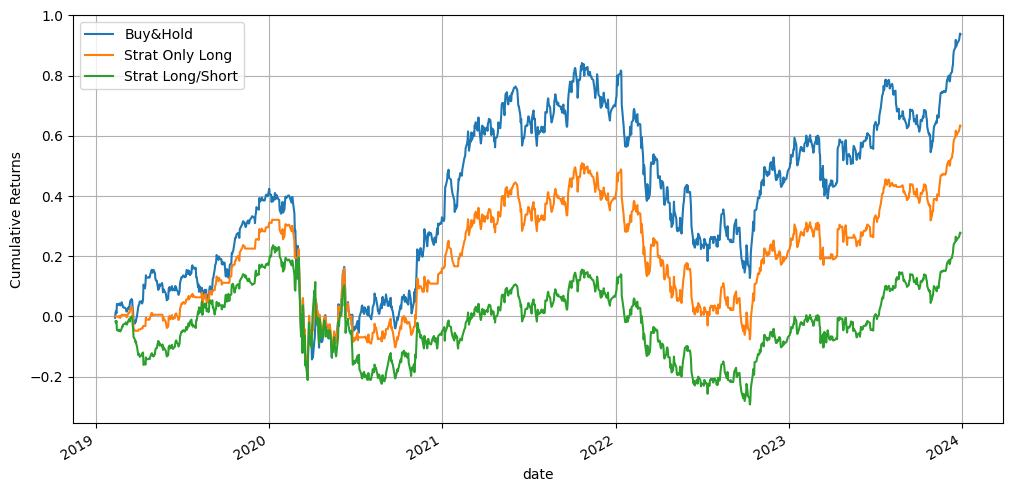

Date         Pred          Ret    Positions  \
count                           1231  1231.000000  1231.000000  1231.000000   
mean   2021-07-20 08:19:29.780666112     0.830219     0.000742     0.660439   
min              2019-02-11 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-04-30 12:00:00     1.000000    -0.008418     1.000000   
50%              2021-07-21 00:00:00     1.000000     0.000671     1.000000   
75%              2022-10-08 12:00:00     1.000000     0.009765     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.375593     0.020249     0.751185   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1230.000000  1230.000000  1230.000000  1230.000000  1230.000000   
mean          0.660163     0.000404     0.830081     0.000575    -0.019387   
min          -1.000000    -0.149649     0.000000    -0.149649    -0.292598   
25%           1.000000    -0.008464     1.000000    -0.006561    -0.100235   
50%           1.000000     0.000544     1.000000     0.000000    -0.022016   
75%           1.000000     0.009833     1.000000     0.007624     0.070790   
max           1.000000     0.180125     1.000000     0.180125     0.278426   
std           0.751428     0.020266     0.375714     0.018808     0.116143   

          CumRet_L        bhRet  
count  1230.000000  1231.000000  
mean      0.196444     0.389394  
min      -0.193035    -0.197317  
25%       0.031181     0.145662  
50%       0.204513     0.403959  
75%       0.335091     0.624588  
max       0.634533     0.939559  
std       0.174311     0.265575

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()

In [ ]:
# Using 50/100 observations for train/test split respectively
n_train = 500
n_test = 100

In [ ]:
time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []


In [ ]:


# Iterate through the dataset and backtest the CNN model
for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X_gaf[i : i + n_train], X_gaf[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + n_train], y[i + n_train : i + n_train + n_test]
    test_time = df1.iloc[i + n_train : i + n_train + n_test, 0:1].values
    Ret_vector = df1.iloc[i + n_train : i + n_train + n_test, 1:2].values
    print(f"ite {i / n_test} -- start test: {test_time[0]} -- end test {test_time[-1]}")

    # Clear previous session and set seed for reproducibility
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)



    # Build CNN model with GAP and L2 Regularization
    model = tf.keras.models.Sequential()

    # First Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_1,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=X_train.shape[1:],
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(n_dropout_1))  # Dropout after first Conv2D layer

    # Second Conv2D layer with L2 regularization
    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters_2,
        kernel_size=(3, 3),
        activation="relu",
        kernel_regularizer=regularizers.l2(hp_l2_reg)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (GAP)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dropout before Dense layer
    model.add(tf.keras.layers.Dropout(n_dropout_dense))

    # Fully connected output layer with 64 units
    model.add(tf.keras.layers.Dense(units=hp_units_dense, activation="relu"))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model with the best learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    # Early stopping callback
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    # Predict and store results
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())


ite 0.0 -- start test: ['2019-02-11T00:00:00.000000000'] -- end test ['2019-07-03T00:00:00.000000000']
ite 1.0 -- start test: ['2019-07-05T00:00:00.000000000'] -- end test ['2019-11-22T00:00:00.000000000']
ite 2.0 -- start test: ['2019-11-25T00:00:00.000000000'] -- end test ['2020-04-20T00:00:00.000000000']
ite 3.0 -- start test: ['2020-04-21T00:00:00.000000000'] -- end test ['2020-09-10T00:00:00.000000000']
ite 4.0 -- start test: ['2020-09-11T00:00:00.000000000'] -- end test ['2021-02-03T00:00:00.000000000']
ite 5.0 -- start test: ['2021-02-04T00:00:00.000000000'] -- end test ['2021-06-28T00:00:00.000000000']
ite 6.0 -- start test: ['2021-06-29T00:00:00.000000000'] -- end test ['2021-11-17T00:00:00.000000000']
ite 7.0 -- start test: ['2021-11-18T00:00:00.000000000'] -- end test ['2022-04-12T00:00:00.000000000']
ite 8.0 -- start test: ['2022-04-13T00:00:00.000000000'] -- end test ['2022-09-06T00:00:00.000000000']
ite 9.0 -- start test: ['2022-09-07T00:00:00.000000000'] -- end test ['20

In [ ]:
df2_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

In [ ]:
df2_predictions["Positions"] = np.where(df2_predictions["Pred"] > 0.5, 1, -1)
df2_predictions["Positions_shift"] = df2_predictions["Positions"].shift(1)
df2_predictions["Strat_ret"] = df2_predictions["Positions"].shift(1) * df2_predictions["Ret"]
df2_predictions["Positions_L"] = df2_predictions["Positions"].shift(1)
df2_predictions["Positions_L"][df2_predictions["Positions_L"] == -1] = 0
df2_predictions["Strat_ret_L"] = df2_predictions["Positions_L"] * df2_predictions["Ret"]
df2_predictions["CumRet"] = df2_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df2_predictions["CumRet_L"] = (
    df2_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df2_predictions["bhRet"] = df2_predictions["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df2_predictions["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df2_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df2_predictions["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Strat Return Long Only = 47.65614821646582 %
Strat Return = -5.011052426553919 %
Buy and Hold Return = 93.72810197710501 %


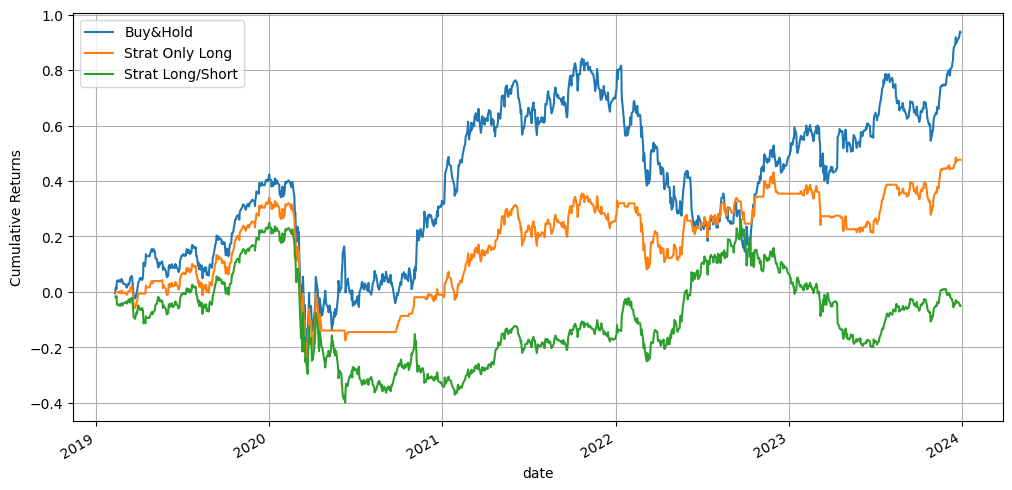

Date         Pred          Ret    Positions  \
count                           1231  1231.000000  1231.000000  1231.000000   
mean   2021-07-20 08:19:29.780666112     0.662876     0.000742     0.325751   
min              2019-02-11 00:00:00     0.000000    -0.149649    -1.000000   
25%              2020-04-30 12:00:00     0.000000    -0.008418    -1.000000   
50%              2021-07-21 00:00:00     1.000000     0.000671     1.000000   
75%              2022-10-08 12:00:00     1.000000     0.009765     1.000000   
max              2023-12-29 00:00:00     1.000000     0.180125     1.000000   
std                              NaN     0.472920     0.020249     0.945840   

       Positions_shift    Strat_ret  Positions_L  Strat_ret_L       CumRet  \
count      1230.000000  1230.000000  1230.000000  1230.000000  1230.000000   
mean          0.326829     0.000165     0.663415     0.000455    -0.089286   
min          -1.000000    -0.149649     0.000000    -0.149649    -0.398754   
25%          -1.000000    -0.008516     0.000000    -0.002909    -0.192214   
50%           1.000000     0.000489     1.000000     0.000000    -0.092433   
75%           1.000000     0.009906     1.000000     0.004711     0.008740   
max           1.000000     0.180125     1.000000     0.180125     0.261689   
std           0.945468     0.020270     0.472734     0.016638     0.154266   

          CumRet_L        bhRet  
count  1230.000000  1231.000000  
mean      0.172619     0.389394  
min      -0.244206    -0.197317  
25%       0.029018     0.145662  
50%       0.226582     0.403959  
75%       0.308810     0.624588  
max       0.484936     0.939559  
std       0.170520     0.265575

In [ ]:
# Plot the backtest results
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df2_predictions.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df2_predictions.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df2_predictions.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df2_predictions.describe()